In [9]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from collections import defaultdict
from scipy.spatial import distance
from scipy.cluster import hierarchy
from pycountry import countries

In [4]:
file_path = "../data/economy_collaborators_network_combine_all_year_quarters_exclude_EU_normalize_sender_only_civilization_countries/economy_collaborators_network_combine_all_exclude_EU_normalize_sender_alpha_0_09_valid_countries.csv"
data = pd.read_csv(file_path)
g = nx.from_pandas_edgelist(data, "source", "destination", ["weight"])

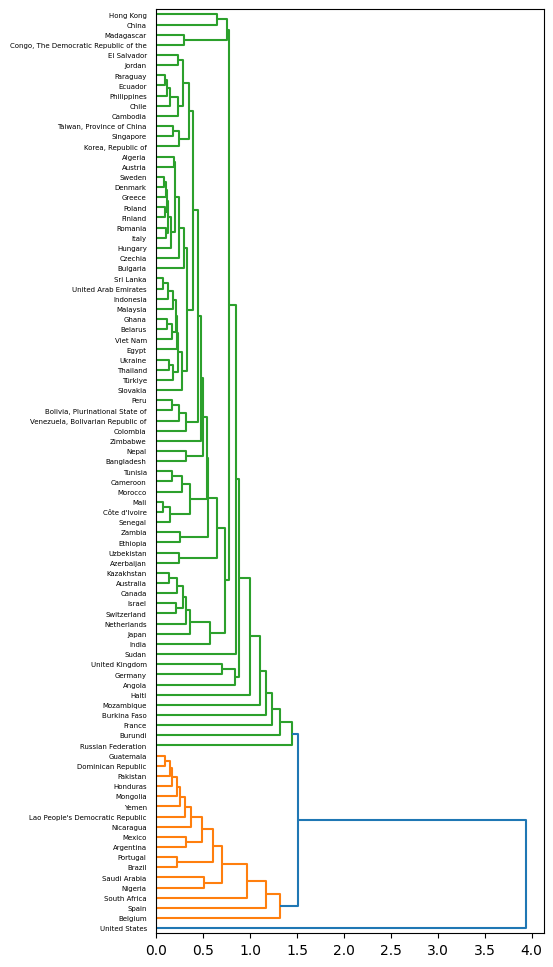

In [20]:
def create_hc(g: nx.DiGraph, t: float):
    distances = np.zeros((len(g), len(g)))
    adj = nx.adjacency_matrix(g, nodelist=sorted(g.nodes)).todense()
    for i in range(len(g)):
        for j in range(len(g)):
            distances[i][j] = distance.euclidean(adj[i], adj[j])
    Y = distance.squareform(distances)
    Z = hierarchy.complete(Y)
    membership = list(hierarchy.fcluster(Z, t=t, criterion="distance"))
    partition = defaultdict(list)
    for n, p in zip(list(range(len(g))), membership):
        partition[p].append(sorted(g.nodes())[n])
    return Z, list(partition.values())

def plot_dendrogram(g: nx.DiGraph, t: float):
    Z, _ = create_hc(g, t=t)
    fig, ax = plt.subplots(1, 1, figsize=(5, 12))

    labels = []
    for n in sorted(g.nodes):
        country = countries.get(alpha_2=n)
        if country is not None:
            labels.append(country.name)
        else:
            labels.append(n)

    hierarchy.dendrogram(Z, ax=ax, labels=labels, orientation="right", color_threshold=t)
    return fig

Z, partitions = create_hc(g, t=1.5)
BM = nx.quotient_graph(g, partitions, create_using=nx.DiGraph)
df = []
node_to_class = []
for i, cluster in enumerate(partitions):
    for node in cluster:
        node_to_class.append({"id": node, "cluster": i, "total": g.degree(weight="weight")[node]})
pd.DataFrame(node_to_class).to_csv(f"../data/blockmodel_clusters.csv", index=False)

df = []
for n1, n2, attrs in BM.edges(data=True):
    weight = 0
    for i in n1:
        for j in n2:
            if g.has_edge(i, j):
                weight += g.edges[i, j]["weight"]
    df.append({"source": n1, "target": n2, "weight": weight})
pd.DataFrame(df).to_csv(f"../data/blockmodel.csv", index=False)
fig = plot_dendrogram(g, t=1.5)